# 深度學習第三次競賽報告 - 第12組 工具人智慧
組員：
<br/>107024501 高瑀鍹
<br/>107024506 王子誠
<br/>107024511 羅揚
<br/>107024522 戴子翔

# Outlines
1. Data Augmentation and Preprocessing
2. char-CNN-RNN Model
3. GAN
4. Loss and Training Strategy
5. Demo
6. Experiments and Finding

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
# Install TensorFlow
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
    
import tensorflow as tf
# import tensorflow_hub as hub
from tensorflow.keras import layers
import os

import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import random
import time
from pathlib import Path

import re
from IPython import display

%matplotlib inline

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 1 Logical GPUs


In [3]:
PATH_TO_DATA = "../data/"
CKPT_DIR = "../ckpts/28_01/"
IFERENCE_PATH = "../inference/28_01-17/"
SAMPLE_DIR = "../samples/28_01/"

checkpoint_name = "28_01"

In [4]:
up_down_flip_p = 0.15
left_right_flip_p = 0.5

noise_p = 0.3
rot_p = 0.4

crop_p = 0.3
brightness_p = 0.15
saturation_p = 0.15
contrast_p = 0.4

In [5]:
dictionary_path = PATH_TO_DATA + 'dictionary/dictionary/'
vocab = np.load(dictionary_path + '/vocab.npy')
print('there are {} vocabularies in total'.format(len(vocab)))

word2Id_dict = dict(np.load(dictionary_path + '/word2Id.npy'))
id2word_dict = dict(np.load(dictionary_path + '/id2Word.npy'))
# print('Word to id mapping, for example: %s -> %s' % ('flower', word2Id_dict['flower']))
# print('Id to word mapping, for example: %s -> %s' % ('1', id2word_dict['1']))
# print('Tokens: <PAD>: %s; <RARE>: %s' % (word2Id_dict['<PAD>'], word2Id_dict['<RARE>']))

there are 5427 vocabularies in total


In [6]:
def sent2IdList(line, MAX_SEQ_LENGTH=20):
    MAX_SEQ_LIMIT = MAX_SEQ_LENGTH
    padding = 0
    
    # data preprocessing, remove all puntuation in the texts
    prep_line = re.sub('[%s]' % re.escape(string.punctuation), ' ', line.rstrip())
    prep_line = prep_line.replace('-', ' ')
    prep_line = prep_line.replace('-', ' ')
    prep_line = prep_line.replace('  ', ' ')
    prep_line = prep_line.replace('.', '')
    tokens = prep_line.split(' ')
    
    tokens = [
        tokens[i] for i in range(len(tokens))
        if tokens[i] != ' ' and tokens[i] != ''
    ]
    
    l = len(tokens)
    padding = MAX_SEQ_LIMIT - l
    
    # make sure length of each text is equal to MAX_SEQ_LENGTH, and replace the less common word with <RARE> token
    for i in range(padding):
        tokens.append('<PAD>')
    line = [
        word2Id_dict[tokens[k]]
        if tokens[k] in word2Id_dict else word2Id_dict['<RARE>']
        for k in range(len(tokens))
    ]

    return line

def idList2sent(idList, is_int=True):
    if is_int:
        return " ".join([id2word_dict[str(i)] for i in idList if id2word_dict[str(i)] != "<PAD>" and id2word_dict[str(i)] != "<RARE>"])
    else:
        return " ".join([id2word_dict[i] for i in idList if id2word_dict[i] != "<PAD>" and id2word_dict[i] != "<RARE>"])
    

text = "the flower shown has yellow anther red pistil and bright red petals."
# print(text)
# print(sent2IdList(text))

In [7]:
data_path = PATH_TO_DATA + 'dataset/dataset/'
df = pd.read_pickle(data_path + '/text2ImgData.pkl')
num_training_sample = len(df)
n_images_train = num_training_sample
# print('There are %d image in training data' % (n_images_train))

In [8]:
def get_masks(tokens, max_seq_length):
    """Mask for padding"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))


def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))


def get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

def get_all(sentence, tokenizer, max_seq_length):
    stokens = tokenizer.tokenize(sentence)
    stokens = ["[CLS]"] + stokens + ["[SEP]"]
    
    input_ids = get_ids(stokens, tokenizer, max_seq_length)
    input_masks = get_masks(stokens, max_seq_length)
    input_segments = get_segments(stokens, max_seq_length)
    
    return input_ids, input_masks, input_segments

def to_bert(caption, max_seq_length=30):
    caption_list = caption.numpy().tolist()
    
    result_ids = []
    result_masks = []
    result_segments = []
    
    for sen in caption_list:
        tmp = idList2sent(sen)
        
        idx, mask, segment = get_all(tmp, tokenizer=TOKENIZER, max_seq_length=max_seq_length)
        
        result_ids.append(idx)
        result_masks.append(mask)
        result_segments.append(segment)
        
    return np.asarray(result_ids), np.asarray(result_masks), np.asarray(result_segments)

def to_use(caption):
    caption_list = caption.numpy()
    
    return np.asarray(idList2sent(caption_list))

In [9]:
@tf.function
def gaussian_noise(image):
    prob = tf.random.uniform([1],0,1)
    
    if prob < noise_p:
        noise = tf.random.normal(image.shape, stddev=0.1)
        image = tf.math.add(image, noise)
        
    return image

@tf.function
def random_flip(image):
    up_down_outcome = tf.random.uniform([1], 0, 1)
    right_left_outcome = tf.random.uniform([1], 0, 1)

    if up_down_outcome<up_down_flip_p:
        image = tf.image.flip_up_down(image)

    if right_left_outcome<left_right_flip_p:
        image = tf.image.flip_left_right(image)

    return image

@tf.function
def random_rot90(image):
    prob = tf.random.uniform([1],0,1)
    
    if prob < (rot_p/2):
        image = tf.image.rot90(image)
    elif (prob >= (rot_p/2)) and (prob < rot_p):
        image = tf.image.rot90(image, k=2)   
        
    return image

@tf.function
def r_crop(image):
    prob = tf.random.uniform([1],0,1)
    
    if prob < crop_p:
        image = tf.image.resize(image, size=[IMAGE_HEIGHT + 5, IMAGE_WIDTH + 5])
        image = tf.image.random_crop(image, size=[IMAGE_HEIGHT, IMAGE_WIDTH, 3])
    else:
        image = tf.image.resize(image, size=[IMAGE_HEIGHT, IMAGE_WIDTH])
        
    return image

@tf.function
def brightness(image):
    prob = tf.random.uniform([1],0,1)
    
    if prob < brightness_p:
        image = tf.image.random_brightness(image, 0.5)
        
    return image

@tf.function
def saturation(image):
    prob = tf.random.uniform([1], 0, 1)
    
    if prob < saturation_p:
        image = tf.image.random_saturation(image, 0.85, 1.5)
        
    return image

@tf.function
def contrast(image):
    prob = tf.random.uniform([1], 0, 1)
    
    if prob < contrast_p:
        image = tf.image.random_contrast(image, 0.9, 2)
        
    return image

## 1. Data Augmentation and Preprocessing

Data augmentation主要分為對Caption與圖片。

Caption:
<br/> 因為一個圖片會對應到多個Caption，所以我們首先嘗試train每個epoch的時候會從所有的句子中隨機抽取一個句子做為該圖片的caption。然而，這個方法的效果比不進行augmentation要來得差許多。我們猜測這可能是因為10個句子太多的緣故，因此，我們也試著只使用5個句子做隨機抽取，但是效果仍然很差，所以我們最後並沒有採用這個augmentation的方法。

圖片:
<br/> 因為大部分的花朵都在圖片的正中央，所以我們先把圖片crop到500x500的大小再進行resize，這樣可以讓圖片有更好的解析度。對於圖片的augmentation，若是有改到圖片的顏色可能會有很嚴重的影響，因此我們主要使用上下左右翻轉與90度旋轉。此外，我們也有使用隨機crop，但若crop的程度太大可能會導致花朵不見，因此我們crop的幅度並不大。
<br/> 根據GAN Tips，我們有試著將圖片normalize到(-1, 1)，但最後我們仍然選擇將圖片normalize到(0, 1)，原因會在之後的Experiments and Finding詳細說明。

In [10]:
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_CHANNEL = 3

def training_data_generator(caption, image_path):
    # load in the image according to image path
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img.set_shape([None, None, 3])
    img = tf.image.resize_with_crop_or_pad(img, 500, 500)
    img = r_crop(img)
    # img = tf.image.resize(img, size=[IMAGE_HEIGHT, IMAGE_WIDTH])
    img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
    
    img = contrast(img)
    # img = brightness(img)
    # img = saturation(img)
    
    # img = 2 * img - 1
    img = random_flip(img)
    img = random_rot90(img)
    # img = gaussian_noise(img)
    
    caption = tf.cast(caption, tf.int32)
    # caption = tf.py_function(func=to_use, inp=[caption], Tout=[tf.string])

    return img, caption

def training_data_generator_only_image(caption, image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img.set_shape([None, None, 3])
    img = tf.image.resize_with_crop_or_pad(img, 500, 500)
    img = r_crop(img)
    # img = tf.image.resize(img, size=[IMAGE_HEIGHT, IMAGE_WIDTH])
    img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
    
    img = contrast(img)
    # img = brightness(img)
    # img = saturation(img)
    
    # img = 2 * img - 1
    img = random_flip(img)
    img = random_rot90(img)
    # img = gaussian_noise(img)
    
    return img

def training_data_generator_only_caption(caption, image_path):
    caption = tf.cast(caption, tf.int32)
    
    return caption

class dataset_generator():
    
    def __init__(self, filenames, batch_size):
        self.batch_size = batch_size
        df = pd.read_pickle(filenames)
        captions = df['Captions'].values
        self.caption = []
        for i in range(len(captions)):
            self.caption.append(random.choice(captions[i]))
        self.caption = np.asarray(self.caption)
        self.caption = self.caption.astype(np.int)
        self.image_path = df['ImagePath'].values
        assert self.caption.shape[0] == self.image_path.shape[0]
        
    def generate(self, generate_func):
        dataset = tf.data.Dataset.from_tensor_slices((self.caption, PATH_TO_DATA + "102flowers/"+ self.image_path))
        dataset = dataset.map(generate_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        dataset = dataset.shuffle(len(self.caption)).batch(self.batch_size, drop_remainder=True)
        dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        
        return dataset

#### 所有Captions隨機抽取

In [ ]:
# in this competition, you have to generate image in size 64x64x3
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_CHANNEL = 3

def training_data_generator(caption, image_path, n_sen):
    # load in the image according to image path
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32) # auto-normalize
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, size=[IMAGE_HEIGHT, IMAGE_WIDTH])

    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = gaussian_noise(img) 

    img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])

    # caption
    qq = tf.random.uniform((), 0, tf.cast(n_sen,tf.float32))
    sample_caption = tf.cast(qq, tf.int32)
    sampled_text = tf.gather(caption, sample_caption, axis=0)
    output_caption = tf.cast(sampled_text, tf.int32)

    return img, output_caption

def dataset_generator(filenames, batch_size, data_generator):
    # load the training data into two NumPy arrays
    df = pd.read_pickle(filenames)
    captions = df['Captions'].values
    
    caption = []
    n_sentence = []
    
    # each image has 1 to 10 corresponding captions
    # we choose one of them randomly for training
    for i in range(len(captions)):
        tmp = np.asarray(captions[i])
        tmp = tmp.astype(np.int)
        
        n_sentence.append(tmp.shape[0])
        
        if tmp.shape[0] < 10:
            zeros_tmp = np.zeros((10 - tmp.shape[0], 20))
            tmp = np.concatenate([tmp,zeros_tmp],axis=0)
        
        caption.append(tmp)
        
    image_path = df['ImagePath'].values
    
    dataset = tf.data.Dataset.from_tensor_slices((caption, PATH_TO_DATA + "102flowers/"+ image_path, n_sentence))
    dataset = dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(len(caption)).batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

#### 5個Captions隨機抽取

In [ ]:
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_CHANNEL = 3

def training_data_generator(caption, image_path):
    img = training_data_generator_only_image(caption, image_path)
    capt = training_data_generator_only_caption(caption, image_path)

    return img, capt

def training_data_generator_only_image(caption, image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img.set_shape([None, None, 3])
    img = tf.image.resize_with_crop_or_pad(img, 500, 500)
    img = r_crop(img)
    # img = tf.image.resize(img, size=[IMAGE_HEIGHT, IMAGE_WIDTH])
    img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
    
    img = 2 * img - 1
    img = random_flip(img)
    img = random_rot90(img)
    # img = gaussian_noise(img)
    
    return img

def training_data_generator_only_caption(caption, image_path):
    # caption
    qq = tf.random.uniform((), 0., 5.)
    sample_caption = tf.cast(qq, tf.int32)
    
    sampled_text = tf.gather(caption, sample_caption, axis=0)
    
    output_caption = tf.cast(sampled_text, tf.int32)
    # output_caption = tf.py_function(func=to_use, inp=[output_caption], Tout=[tf.string])
    
    return output_caption

class dataset_generator():
    
    def __init__(self, filenames, batch_size):
        self.batch_size = batch_size
        
        df = pd.read_pickle(filenames)
        captions = df['Captions'].values
        self.caption = []
        
        for i in range(len(captions)):
            assert len(captions[i]) >= 5
            
            tmp = np.asarray(captions[i][:5])
            tmp = tmp.astype(np.int)
            self.caption.append(tmp)
            
        self.image_path = df['ImagePath'].values
        assert len(self.caption) == self.image_path.shape[0]
        
    def generate(self, generate_func):
        dataset = tf.data.Dataset.from_tensor_slices((self.caption,
                                                      PATH_TO_DATA + "102flowers/"+ self.image_path))
        dataset = dataset.map(generate_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        dataset = dataset.shuffle(len(self.caption)).batch(self.batch_size, drop_remainder=True)
        dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        
        return dataset

In [11]:
BATCH_SIZE = 64

ds_generator = dataset_generator(data_path + '/text2ImgData.pkl', BATCH_SIZE)

dataset = ds_generator.generate(training_data_generator)
dataset_wrong_image = ds_generator.generate(training_data_generator_only_image)
dataset_wrong_caption = ds_generator.generate(training_data_generator_only_caption)

## 2. char-CNN-RNN Model

對於Sentence embedding的部分，我們參考paper使用char-CNN-RNN Model進行embedding。
<br/> 為了考量到文字前後的相關性，我們的char-CNN-RNN Model主要是使用Bidirectional GRU來對句子進行embedding，另一方面，我們使用一般的CNN模型並在最後加上一層fully connected layer以確保其維度與Bidirectional GRU一致。計算loss的部分則是使用cosine來計算正確配對與錯誤配對的cosine similarity，希望配對錯誤的similarity可以降低，正確配對的similarity可以升高。
<br/> 除了char-CNN-RNN Model之外，我們也嘗試過使用Universal Sentence Encoder (USE)進行Sentence embedding，但是使用USE的效果非常的差，因此我們沒有繼續使用。這可能是因為我們單純使用USE embedding出來的結果使效果沒有很好，若可以結合char-CNN-RNN Model與USE或許可以得到更好的結果。

In [12]:
class TextEncoder(tf.keras.Model):
    """
    Encode text (a caption) into hidden representation
    input: text, which is a list of ids
    output: embedding, or hidden representation of input text in dimension of RNN_HIDDEN_SIZE
    """
    def __init__(self, hparas):
        super(TextEncoder, self).__init__()
        self.hparas = hparas
        self.batch_size = self.hparas['BATCH_SIZE']
        self.hidden_size = int(self.hparas['T_DIM'] / 2)
        
        # embedding with tensorflow API
        self.embedding = layers.Embedding(self.hparas['VOCAB_SIZE'], self.hparas['EMBED_DIM'])
        # RNN, here we use GRU cell, another common RNN cell similar to LSTM
        self.gru = layers.GRU(self.hidden_size,
                              return_sequences=True,
                              return_state=True,
                              recurrent_initializer='glorot_uniform')
        self.bid = layers.Bidirectional(self.gru)
    
    def call(self, text, hidden):
        text = self.embedding(text)
        output, state1, state2 = self.bid(text, initial_state = hidden)
        return output[:, -1, :], state1
    
    def initialize_hidden_state(self):
        return [tf.zeros((self.hparas['BATCH_SIZE'], self.hidden_size)) for i in range(2)]

In [13]:
class cnn_encoder(tf.keras.Model):
    def __init__(self, inputs, is_training=True, reuse=False):
        super(cnn_encoder, self).__init__()
        # self.inputs = inputs
        # self.is_training = is_training
        # self.reuse = reuse
        self.hparas = hparas
        self.df_dim = 64
        self.t_dim = self.hparas['T_DIM']
        
        self.net_h0_conv2d = tf.keras.layers.Conv2D(self.df_dim, 4, 2, padding='SAME',use_bias=True, kernel_initializer= tf.random_normal_initializer(stddev=0.02))
        self.net_h1_conv2d = tf.keras.layers.Conv2D(self.df_dim*2, 4, 2, padding='SAME',use_bias=True, kernel_initializer= tf.random_normal_initializer(stddev=0.02))
        self.bn1 = tf.keras.layers.BatchNormalization()
        
        self.net_h2_conv2d = tf.keras.layers.Conv2D(self.df_dim*4, 4, 2, padding='SAME',use_bias=True, kernel_initializer= tf.random_normal_initializer(stddev=0.02))
        self.bn2 = tf.keras.layers.BatchNormalization()
        
        self.net_h3_conv2d = tf.keras.layers.Conv2D(self.df_dim*8, 4, 2, padding='SAME',use_bias=True, kernel_initializer= tf.random_normal_initializer(stddev=0.02))
        self.bn3 = tf.keras.layers.BatchNormalization()

        self.net_h4_flat = tf.keras.layers.Flatten()
        self.net_h4_fc = tf.keras.layers.Dense(self.t_dim, use_bias=False, kernel_initializer= tf.random_normal_initializer(stddev=0.02))

    def call(self, inputs, is_training = True):
        net_h0 = self.net_h0_conv2d(inputs)
        net_h0 = tf.nn.leaky_relu(net_h0)
        
        net_h1 = self.net_h1_conv2d(net_h0)
        net_h1 = self.bn1(net_h1, training=is_training)
        net_h1 = tf.nn.leaky_relu(net_h1)

        net_h2 = self.net_h2_conv2d(net_h1)
        net_h2 = self.bn2(net_h2, training=is_training)
        net_h2 = tf.nn.leaky_relu(net_h2)

        net_h3 = self.net_h3_conv2d(net_h2)
        net_h3 = self.bn3(net_h3, training=is_training)
        net_h3 = tf.nn.leaky_relu(net_h3)

        net_h4 = self.net_h4_flat(net_h3)
        net_h4 = self.net_h4_fc(net_h4)

        outputs = net_h4

        return outputs       


#### Universal Sentence Encoder (USE)

In [ ]:
text_encoder = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

## 3. GAN

我們的GAN架構首先參考paper上的架構再往下延伸。Discriminator的部分，我們使用5層的Convolution layers以及兩層fully connected layers (一層為text使用、一層為output使用)，Generator的部分，我們則是使用4層Transposed convolution layers以及一層text使用的fully connected layer。此外，我們參考Stack GAN的作法，在Generator的部分加入noise，以增強同一個condition之下的圖片差異性。
<br/> 除了這個模型之外，我們有嘗試在Generator的結構中加入Residual connection。效果是大幅節省訓練的時間（一個Epoch只要約一半的時間），但是產生的圖片品質比原本較簡單的model差，因此最後沒有採用。
<br/> 我們也試過更深層的Generator與Discriminator，但效果也是非常的差，因此最後也沒有採用。

In [14]:
class Generator(tf.keras.Model):
    """
    Generate fake image based on given text(hidden representation) and noise z
    input: text and noise
    output: fake image with size 64*64*3
    """
    def __init__(self, hparas):
        super(Generator, self).__init__()
        self.hparas = hparas
        self.t_dim = self.hparas['T_DIM'] * 2
        self.gf_dim = 64
        self.image_size = self.hparas['IMAGE_SIZE'][0]
        self.c_dim = self.hparas['IMAGE_SIZE'][2]
        # self.latent_shape = self.hparas["PRE_TRAIND_TEXT_EMBBEDING"] + self.hparas['DENSE_DIM']
        
        self.s2, self.s4 = int(self.image_size/2), int(self.image_size/4)
        self.s8, self.s16 = int(self.image_size/8), int(self.image_size/16)
        
        ######
        self.net_txt_fc1 = tf.keras.layers.Dense(self.t_dim)
        
        self.h0_fc1 = tf.keras.layers.Dense(self.s16 * self.s16 * 8 * self.gf_dim)
        self.h0_bn1 = tf.keras.layers.BatchNormalization()
        
        self.reshape = tf.keras.layers.Reshape(target_shape = (self.s16, self.s16, 8 * self.gf_dim))
        
        self.h1_tConv1 = tf.keras.layers.Conv2DTranspose(self.gf_dim * 4, 5, 2, padding='SAME')
        self.h1_bn1 = tf.keras.layers.BatchNormalization()

        self.h2_tConv1 = tf.keras.layers.Conv2DTranspose(self.gf_dim * 2, 5, 2, padding='SAME')
        self.h2_bn1 = tf.keras.layers.BatchNormalization()

        self.h3_tConv1 = tf.keras.layers.Conv2DTranspose(self.gf_dim * 1, 5, 2, padding='SAME')
        self.h3_bn1 = tf.keras.layers.BatchNormalization()

        self.hout = tf.keras.layers.Conv2DTranspose(self.c_dim, 5, 2, padding='SAME')
        
    def call(self, text, noise_z, is_training=True):
        net_txt = self.net_txt_fc1(text)
        net_txt = tf.nn.leaky_relu(net_txt)
        
        mean_d = net_txt[:,:(tf.cast(self.t_dim/2,tf.int32))]
        stddev = tf.math.exp(net_txt[:,(tf.cast(self.t_dim/2,tf.int32)):])
        
        if is_training:
            epsilon = tf.random.normal(mean_d.shape)
            net_txt = mean_d + stddev * epsilon
        else:
            net_txt = mean_d
        
        x = tf.concat([noise_z, net_txt], axis=1)
        
        # h0
        x = self.h0_fc1(x)
        
        x = self.reshape(x)
        x = self.h0_bn1(x)
        x = tf.nn.relu(x)
        
        # h1
        x = self.h1_tConv1(x)
        x = self.h1_bn1(x)
        x = tf.nn.relu(x)

        # h2
        x = self.h2_tConv1(x)
        x = self.h2_bn1(x)
        x = tf.nn.relu(x)
    
        # h3
        x = self.h3_tConv1(x)
        x = self.h3_bn1(x)
        x = tf.nn.relu(x)
        
        # hout
        logits = self.hout(x) # logits
        output = tf.nn.tanh(logits)*0.5 + 0.5
        
        return logits, output

In [15]:
class Discriminator(tf.keras.Model):
    """
    Differentiate the real and fake image
    input: image and corresponding text
    output: labels, the real image should be 1, while the fake should be 0
    """
    def __init__(self, hparas):
        super(Discriminator, self).__init__()
        self.hparas = hparas
        self.t_dim = self.hparas['T_DIM']
        self.df_dim = 64
        self.image_size = self.hparas['IMAGE_SIZE'][0]
        
        self.s2, self.s4 = int(self.image_size/2), int(self.image_size/4)
        self.s8, self.s16 = int(self.image_size/8), int(self.image_size/16)
        
        self.h0_Conv1 = tf.keras.layers.Conv2D(self.df_dim, 5, 2, padding='SAME')

        self.h1_Conv1 = tf.keras.layers.Conv2D(self.df_dim*2, 5, 2, padding='SAME')
        self.h1_bn1 = tf.keras.layers.BatchNormalization()

        self.h2_Conv1 = tf.keras.layers.Conv2D(self.df_dim*4, 5, 2, padding='SAME')
        self.h2_bn1 = tf.keras.layers.BatchNormalization()

        self.h3_Conv1 = tf.keras.layers.Conv2D(self.df_dim*8, 5, 2, padding='SAME')
        self.h3_bn1 = tf.keras.layers.BatchNormalization()

        self.net_txt_fc1 = tf.keras.layers.Dense(self.t_dim)

        self.h4_Conv1 = tf.keras.layers.Conv2D(self.df_dim*8, 1, 1, padding='SAME')
        self.h4_bn1 = tf.keras.layers.BatchNormalization()
        
        self.flatten = tf.keras.layers.Flatten()
        self.hout = tf.keras.layers.Dense(1)
        
    def call(self, img, text):
        x = self.h0_Conv1(img)
        x = tf.nn.leaky_relu(x)

        x = self.h1_Conv1(x)
        x = self.h1_bn1(x)
        x = tf.nn.leaky_relu(x)

        x = self.h2_Conv1(x)
        x = self.h2_bn1(x)
        x = tf.nn.leaky_relu(x)

        x = self.h3_Conv1(x)
        x = self.h3_bn1(x)
        x = tf.nn.leaky_relu(x)

        ####
        net_txt = self.net_txt_fc1(text)
        net_txt = tf.nn.leaky_relu(net_txt)
        net_txt = tf.expand_dims(net_txt, axis=1)
        net_txt = tf.expand_dims(net_txt, axis=2)
        net_txt = tf.tile(net_txt, [1, 4, 4, 1])
        
        x = tf.concat([x, net_txt], axis=3)
        
        x = self.h4_Conv1(x)
        x = self.h4_bn1(x)
        x = tf.nn.leaky_relu(x)
        
        x = self.flatten(x)
        
        logits = self.hout(x) # logits
        output = tf.nn.sigmoid(logits)
        
        return logits, output

#### Residual Connection

In [ ]:
class Generator(tf.keras.Model):
    """
    Generate fake image based on given text(hidden representation) and noise z
    input: text and noise
    output: fake image with size 64*64*3
    """
    def __init__(self, hparas):
        super(Generator, self).__init__()
        self.hparas = hparas
        self.t_dim = self.hparas['T_DIM'] * 2
        self.gf_dim = 64
        self.image_size = self.hparas['IMAGE_SIZE'][0]
        self.c_dim = self.hparas['IMAGE_SIZE'][2]
        # self.latent_shape = self.hparas["PRE_TRAIND_TEXT_EMBBEDING"] + self.hparas['DENSE_DIM']
        
        self.s2, self.s4 = int(self.image_size/2), int(self.image_size/4)
        self.s8, self.s16 = int(self.image_size/8), int(self.image_size/16)
        
        ######
        self.net_txt_fc1 = tf.keras.layers.Dense(self.t_dim)
        
        self.h0_fc1 = tf.keras.layers.Dense(self.s16 * self.s16 * 8 * self.gf_dim)
        self.h0_bn1 = tf.keras.layers.BatchNormalization()
        
        self.reshape = tf.keras.layers.Reshape(target_shape = (self.s16, self.s16, 8 * self.gf_dim))
        
        self.h1_Conv1 = tf.keras.layers.Conv2D(self.gf_dim * 2, 1, 1, padding='SAME')
        self.h1_bn1 = tf.keras.layers.BatchNormalization()
        self.h1_Conv2 = tf.keras.layers.Conv2D(self.gf_dim * 2, 3, 1, padding='SAME')
        self.h1_bn2 = tf.keras.layers.BatchNormalization()
        self.h1_Conv3 = tf.keras.layers.Conv2D(self.gf_dim * 8, 3, 1, padding='SAME')
        self.h1_bn3 = tf.keras.layers.BatchNormalization()
        self.h1_tConv1 = tf.keras.layers.Conv2DTranspose(self.gf_dim * 4, 4, 2, padding='SAME', use_bias=False)
        self.h1_bn4 = tf.keras.layers.BatchNormalization()
        
        self.h2_Conv1 = tf.keras.layers.Conv2D(self.gf_dim * 1, 1, 1, padding='SAME')
        self.h2_bn1 = tf.keras.layers.BatchNormalization()
        self.h2_Conv2 = tf.keras.layers.Conv2D(self.gf_dim * 1, 3, 1, padding='SAME')
        self.h2_bn2 = tf.keras.layers.BatchNormalization()
        self.h2_Conv3 = tf.keras.layers.Conv2D(self.gf_dim * 4, 3, 1, padding='SAME')
        self.h2_bn3 = tf.keras.layers.BatchNormalization()
        self.h2_tConv1 = tf.keras.layers.Conv2DTranspose(self.gf_dim * 2, 4, 2, padding='SAME', use_bias=False)
        self.h2_bn4 = tf.keras.layers.BatchNormalization()

        self.h3_tConv1 = tf.keras.layers.Conv2DTranspose(self.gf_dim * 1, 4, 2, padding='SAME', use_bias=False)
        self.h3_bn1 = tf.keras.layers.BatchNormalization()

        self.hout = tf.keras.layers.Conv2DTranspose(self.c_dim, 4, 2, padding='SAME', use_bias=False)
        
    def call(self, text, noise_z, is_training=True):
        net_txt = self.net_txt_fc1(text)
        net_txt = tf.nn.leaky_relu(net_txt)
        
        mean_d = net_txt[:,:(tf.cast(self.t_dim/2,tf.int32))]
        stddev = tf.math.exp(net_txt[:,(tf.cast(self.t_dim/2,tf.int32)):])
        
        if is_training:
            epsilon = tf.random.normal(mean_d.shape)
            net_txt = mean_d + stddev * epsilon
        else:
            net_txt = mean_d
        
        x = tf.concat([noise_z, net_txt], axis=1)
        
        # h0
        x = self.h0_fc1(x)
        
        x = self.reshape(x)
        h0 = self.h0_bn1(x)
        
        # h1
        x = self.h1_Conv1(h0)
        x = self.h1_bn1(x)
        x = tf.nn.relu(x)
        
        x = self.h1_Conv2(x)
        x = self.h1_bn2(x)
        x = tf.nn.relu(x)
        
        x = self.h1_Conv3(x)
        x = self.h1_bn3(x)
        
        x = tf.nn.relu(tf.keras.layers.add([h0, x]))
        x = self.h1_tConv1(x)
        h1 = self.h1_bn4(x)

        # h2
        x = self.h2_Conv1(h1)
        x = self.h2_bn1(x)
        x = tf.nn.relu(x)
        
        x = self.h2_Conv2(x)
        x = self.h2_bn2(x)
        x = tf.nn.relu(x)
        
        x = self.h2_Conv3(x)
        x = self.h2_bn3(x)
        
        x = tf.nn.relu(tf.keras.layers.add([h1, x]))
        x = self.h2_tConv1(x)
        x = self.h2_bn4(x)
        x = tf.nn.relu(x)
    
        # h3
        x = self.h3_tConv1(x)
        x = self.h3_bn1(x)
        
        # hout       
        logits = self.hout(x) # logits
        output = tf.nn.tanh(logits)
        
        return logits, output

In [ ]:
class Discriminator(tf.keras.Model):
    """
    Differentiate the real and fake image
    input: image and corresponding text
    output: labels, the real image should be 1, while the fake should be 0
    """
    def __init__(self, hparas):
        super(Discriminator, self).__init__()
        self.hparas = hparas
        self.t_dim = self.hparas['T_DIM']
        self.df_dim = 64
        self.image_size = self.hparas['IMAGE_SIZE'][0]
        
        self.s2, self.s4 = int(self.image_size/2), int(self.image_size/4)
        self.s8, self.s16 = int(self.image_size/8), int(self.image_size/16)
        
        self.h0_Conv1 = tf.keras.layers.Conv2D(self.df_dim, 4, 2, padding='SAME')

        self.h1_Conv1 = tf.keras.layers.Conv2D(self.df_dim*2, 4, 2, padding='SAME')
        self.h1_bn1 = tf.keras.layers.BatchNormalization()

        self.h2_Conv1 = tf.keras.layers.Conv2D(self.df_dim*4, 4, 2, padding='SAME')
        self.h2_bn1 = tf.keras.layers.BatchNormalization()

        self.h3_Conv1 = tf.keras.layers.Conv2D(self.df_dim*8, 4, 2, padding='SAME')
        self.h3_bn1 = tf.keras.layers.BatchNormalization()

        self.net_txt_fc1 = tf.keras.layers.Dense(self.t_dim)

        self.h4_Conv1 = tf.keras.layers.Conv2D(self.df_dim*8, 1, 1, padding='valid')
        self.h4_bn1 = tf.keras.layers.BatchNormalization()
        
        self.flatten = tf.keras.layers.Flatten()
        self.hout = tf.keras.layers.Dense(1)
        
    def call(self, img, text):
        x = self.h0_Conv1(img)
        x = tf.nn.leaky_relu(x)

        x = self.h1_Conv1(x)
        x = self.h1_bn1(x)
        x = tf.nn.leaky_relu(x)

        x = self.h2_Conv1(x)
        x = self.h2_bn1(x)
        x = tf.nn.leaky_relu(x)

        x = self.h3_Conv1(x)
        x = self.h3_bn1(x)
        x = tf.nn.leaky_relu(x)

        ####
        net_txt = self.net_txt_fc1(text)
        net_txt = tf.nn.leaky_relu(net_txt)
        net_txt = tf.expand_dims(net_txt, axis=1)
        net_txt = tf.expand_dims(net_txt, axis=2)
        net_txt = tf.tile(net_txt, [1, 4, 4, 1])
        
        x = tf.concat([x, net_txt], axis=3)
        
        x = self.h4_Conv1(x)
        x = self.h4_bn1(x)
        x = tf.nn.leaky_relu(x)
        
        x = self.flatten(x)
        
        logits = self.hout(x) # logits
        output = tf.nn.sigmoid(logits)
        
        return logits, output

#### 深層架構

In [ ]:
class Generator(tf.keras.Model):
    """
    Generate fake image based on given text(hidden representation) and noise z
    input: text and noise
    output: fake image with size 64*64*3
    """
    def __init__(self, hparas):
        super(Generator, self).__init__()
        self.hparas = hparas
        self.t_dim = self.hparas['T_DIM'] * 2
        self.gf_dim = 64
        self.image_size = self.hparas['IMAGE_SIZE'][0]
        self.c_dim = self.hparas['IMAGE_SIZE'][2]
        # self.latent_shape = self.hparas["PRE_TRAIND_TEXT_EMBBEDING"] + self.hparas['DENSE_DIM']
        
        self.s2, self.s4 = int(self.image_size/2), int(self.image_size/4)
        self.s8, self.s16 = int(self.image_size/8), int(self.image_size/16)
        
        ######
        self.net_txt_fc1 = tf.keras.layers.Dense(self.t_dim, kernel_initializer= tf.random_normal_initializer(stddev=0.02))
        
        self.h0_fc1 = tf.keras.layers.Dense(self.s16 * self.s16 * 8 * self.gf_dim, kernel_initializer= tf.random_normal_initializer(stddev=0.02))
        self.h0_bn1 = tf.keras.layers.BatchNormalization()
        
        self.reshape = tf.keras.layers.Reshape(target_shape = (self.s16, self.s16, 8 * self.gf_dim))
        
        self.h1_tConv2 = tf.keras.layers.Conv2DTranspose(self.gf_dim * 4, 4, 1, padding='SAME', kernel_initializer= tf.random_normal_initializer(stddev=0.02))
        self.h1_bn2 = tf.keras.layers.BatchNormalization()
        self.h1_tConv1 = tf.keras.layers.Conv2DTranspose(self.gf_dim * 4, 5, 2, padding='SAME', kernel_initializer= tf.random_normal_initializer(stddev=0.02))
        self.h1_bn1 = tf.keras.layers.BatchNormalization()
        
        self.h2_tConv2 = tf.keras.layers.Conv2DTranspose(self.gf_dim * 2, 4, 1, padding='SAME', kernel_initializer= tf.random_normal_initializer(stddev=0.02))
        self.h2_bn2 = tf.keras.layers.BatchNormalization()
        self.h2_tConv1 = tf.keras.layers.Conv2DTranspose(self.gf_dim * 2, 5, 2, padding='SAME', kernel_initializer= tf.random_normal_initializer(stddev=0.02))
        self.h2_bn1 = tf.keras.layers.BatchNormalization()
        
        self.h3_tConv2 = tf.keras.layers.Conv2DTranspose(self.gf_dim * 1, 4, 1, padding='SAME', kernel_initializer= tf.random_normal_initializer(stddev=0.02))
        self.h3_bn2 = tf.keras.layers.BatchNormalization()
        self.h3_tConv1 = tf.keras.layers.Conv2DTranspose(self.gf_dim * 1, 5, 2, padding='SAME', kernel_initializer= tf.random_normal_initializer(stddev=0.02))
        self.h3_bn1 = tf.keras.layers.BatchNormalization()
        
        self.hout = tf.keras.layers.Conv2DTranspose(self.c_dim, 5, 2, padding='SAME', kernel_initializer= tf.random_normal_initializer(stddev=0.02))
        
    def call(self, text, noise_z, is_training=True):
        net_txt = self.net_txt_fc1(text)
        net_txt = tf.nn.leaky_relu(net_txt)
        
        mean_d = net_txt[:,:(tf.cast(self.t_dim/2,tf.int32))]
        stddev = tf.math.exp(net_txt[:,(tf.cast(self.t_dim/2,tf.int32)):])
        
        if True:
            epsilon = tf.random.truncated_normal(mean_d.shape)
            net_txt = mean_d + stddev * epsilon
        else:
            net_txt = mean_d
        
        x = tf.concat([noise_z, net_txt], axis=1)
        
        # h0
        x = self.h0_fc1(x)
        
        x = self.reshape(x)
        x = self.h0_bn1(x)
        x = tf.nn.relu(x)
        
        # h1
        x = self.h1_tConv2(x)
        x = self.h1_bn2(x)
        x = tf.nn.relu(x)
        x = self.h1_tConv1(x)
        x = self.h1_bn1(x)
        x = tf.nn.relu(x)

        # h2
        x = self.h2_tConv2(x)
        x = self.h2_bn2(x)
        x = tf.nn.relu(x)
        x = self.h2_tConv1(x)
        x = self.h2_bn1(x)
        x = tf.nn.relu(x)
    
        # h3
        x = self.h3_tConv2(x)
        x = self.h3_bn2(x)
        x = tf.nn.relu(x)
        x = self.h3_tConv1(x)
        x = self.h3_bn1(x)
        x = tf.nn.relu(x)
        
        # hout
        logits = self.hout(x) # logits
        output = tf.nn.tanh(logits)
        
        return logits, output

In [ ]:
class Discriminator(tf.keras.Model):
    """
    Differentiate the real and fake image
    input: image and corresponding text
    output: labels, the real image should be 1, while the fake should be 0
    """
    def __init__(self, hparas):
        super(Discriminator, self).__init__()
        self.hparas = hparas
        self.t_dim = self.hparas['T_DIM']
        self.df_dim = 64
        self.image_size = self.hparas['IMAGE_SIZE'][0]
        
        self.s2, self.s4 = int(self.image_size/2), int(self.image_size/4)
        self.s8, self.s16 = int(self.image_size/8), int(self.image_size/16)
        
        self.h0_Conv1 = tf.keras.layers.Conv2D(self.df_dim, 5, 2, padding='SAME', kernel_initializer= tf.random_normal_initializer(stddev=0.02))

        self.h1_Conv1 = tf.keras.layers.Conv2D(self.df_dim*2, 5, 2, padding='SAME', kernel_initializer= tf.random_normal_initializer(stddev=0.02))
        self.h1_bn1 = tf.keras.layers.BatchNormalization()
        self.h1_Conv2 = tf.keras.layers.Conv2D(self.df_dim*2, 4, 1, padding='SAME', kernel_initializer= tf.random_normal_initializer(stddev=0.02))
        self.h1_bn2 = tf.keras.layers.BatchNormalization()

        self.h2_Conv1 = tf.keras.layers.Conv2D(self.df_dim*4, 5, 2, padding='SAME', kernel_initializer= tf.random_normal_initializer(stddev=0.02))
        self.h2_bn1 = tf.keras.layers.BatchNormalization()
        self.h2_Conv2 = tf.keras.layers.Conv2D(self.df_dim*4, 4, 1, padding='SAME', kernel_initializer= tf.random_normal_initializer(stddev=0.02))
        self.h2_bn2 = tf.keras.layers.BatchNormalization()

        self.h3_Conv1 = tf.keras.layers.Conv2D(self.df_dim*8, 5, 2, padding='SAME', kernel_initializer= tf.random_normal_initializer(stddev=0.02))
        self.h3_bn1 = tf.keras.layers.BatchNormalization()
        self.h3_Conv2 = tf.keras.layers.Conv2D(self.df_dim*8, 4, 1, padding='SAME', kernel_initializer= tf.random_normal_initializer(stddev=0.02))
        self.h3_bn2 = tf.keras.layers.BatchNormalization()

        self.net_txt_fc1 = tf.keras.layers.Dense(self.t_dim, kernel_initializer= tf.random_normal_initializer(stddev=0.02))

        self.h4_Conv1 = tf.keras.layers.Conv2D(self.df_dim*8, 1, 1, padding='SAME', kernel_initializer= tf.random_normal_initializer(stddev=0.02))
        self.h4_bn1 = tf.keras.layers.BatchNormalization()
        
        self.flatten = tf.keras.layers.Flatten()
        self.hout = tf.keras.layers.Dense(1, kernel_initializer= tf.random_normal_initializer(stddev=0.02))
        
    def call(self, img, text):
        x = self.h0_Conv1(img)
        x = tf.nn.leaky_relu(x)

        x = self.h1_Conv1(x)
        x = self.h1_bn1(x)
        x = tf.nn.leaky_relu(x)
        x = self.h1_Conv2(x)
        x = self.h1_bn2(x)
        x = tf.nn.leaky_relu(x)

        x = self.h2_Conv1(x)
        x = self.h2_bn1(x)
        x = tf.nn.leaky_relu(x)
        x = self.h2_Conv2(x)
        x = self.h2_bn2(x)
        x = tf.nn.leaky_relu(x)

        x = self.h3_Conv1(x)
        x = self.h3_bn1(x)
        x = tf.nn.leaky_relu(x)
        x = self.h3_Conv2(x)
        x = self.h3_bn2(x)
        x = tf.nn.leaky_relu(x)

        ####
        net_txt = self.net_txt_fc1(text)
        net_txt = tf.nn.leaky_relu(net_txt)
        net_txt = tf.expand_dims(net_txt, axis=1)
        net_txt = tf.expand_dims(net_txt, axis=2)
        net_txt = tf.tile(net_txt, [1, 4, 4, 1])
        
        x = tf.concat([x, net_txt], axis=3)
        
        x = self.h4_Conv1(x)
        x = self.h4_bn1(x)
        x = tf.nn.leaky_relu(x)
        
        x = self.flatten(x)
        
        logits = self.hout(x) # logits
        output = tf.nn.sigmoid(logits)
        
        return logits, output

In [16]:
hparas = {
    'MAX_SEQ_LENGTH': 20,                     # maximum sequence length
    'EMBED_DIM': 128,                         # word embedding dimension
    'VOCAB_SIZE': len(word2Id_dict),          # size of dictionary of captions
    "T_DIM": 64,
    'RNN_HIDDEN_SIZE': 64,                    # number of RNN neurons (aligned with T_DIM)
    'Z_DIM': 100,                             # random noise z dimension
    'DENSE_DIM': 128,                         # number of neurons in dense layer
    'IMAGE_SIZE': [64, 64, 3],                # render image size
    'BATCH_SIZE': 64,
    'LR': 1e-4,
    'LR_DECAY': 0.5,
    'BETA_1': 0.5,
    'N_EPOCH': 900,
    'N_SAMPLE': num_training_sample,          # size of training data
    'CHECKPOINTS_DIR': CKPT_DIR,  # checkpoint path
    'PRINT_FREQ': 1                        # printing frequency of loss                        
}

In [17]:
text_encoder = TextEncoder(hparas)
cnn_encoder = cnn_encoder(hparas)
generator = Generator(hparas)
discriminator = Discriminator(hparas)

In [18]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [19]:
@tf.function
def grad_pentalty(disc, x, real_embed):
    with tf.GradientTape() as tape:
        tape.watch(x)
        y = disc(x, real_embed)
    
    grad = tape.gradient(y, x)
    norm_grad = tf.sqrt(tf.reduce_sum(grad ** 2, axis=[1, 2, 3]))
    output = tf.reduce_mean((norm_grad - 1.0) ** 2)
    
    return output

## 4. Loss and Training Strategy

根據paper上的演算法，我們在Discriminator loss的部分加了錯誤文字配上正確圖片的pair，此外，我們也有嘗試過增加錯誤圖片配上正確文字的pair，但加上這個組合後效果並沒有提升。
<br/> 考量到一開始char-CNN-RNN模型的效果還很差的情況下，若同時train GAN可能會導致GAN的參數受到影響，導致GAN train不好。因此，我們先train char-CNN-RNN模型50個epoch，之後才會train GAN。
<br/> 考慮到char-CNN-RNN中有RNN的存在，我們的char-CNN-RNN的optimizer有進行clip的行為，避免gradient大量增加。

In [20]:
def discriminator_loss(real_logits, fake_logits, mismatch_text_logits):
    # output value of real image should be 1
    real_loss = cross_entropy(y_true=tf.ones_like(real_logits), y_pred=real_logits)
    # output value of fake image should be 0
    fake_loss = cross_entropy(y_true=tf.zeros_like(fake_logits), y_pred=fake_logits)
    mismatch_text_loss = cross_entropy(y_true=tf.zeros_like(mismatch_text_logits), y_pred=mismatch_text_logits) # wrong text
    # mismatch_image_loss = cross_entropy(y_true=tf.zeros_like(mismatch_image_logits), y_pred=mismatch_image_logits) # wrong image
    total_loss = real_loss + ((fake_loss + mismatch_text_loss)/2)
    # total_loss = real_loss + ((fake_loss + mismatch_text_loss + mismatch_image_loss)/3)
    
    return total_loss

def generator_loss(fake_output):
    # output value of fake image should be 0
    return cross_entropy(tf.ones_like(fake_output), fake_output)
    # return -tf.reduce_mean(fake_output)

In [21]:
alpha = 0.2
def cosine_similarity(v1, v2):
    cost = tf.reduce_sum(tf.multiply(v1, v2), 1) / (tf.sqrt(tf.reduce_sum(tf.multiply(v1, v1), 1)) * tf.sqrt(tf.reduce_sum(tf.multiply(v2, v2), 1)))
    return cost

def rnn_loss(real_cnn, text_embed, wrong_cnn, wrong_text_embed):
    rnn_loss = tf.reduce_mean(tf.maximum(0., alpha - cosine_similarity(real_cnn, text_embed) + cosine_similarity(real_cnn, wrong_text_embed))) + \
                tf.reduce_mean(tf.maximum(0., alpha - cosine_similarity(real_cnn, text_embed) + cosine_similarity(wrong_cnn, text_embed)))   
    return rnn_loss

In [22]:
# we use seperated optimizers for training generator and discriminator
generator_optimizer = tf.keras.optimizers.Adam(hparas['LR'])
discriminator_optimizer = tf.keras.optimizers.Adam(hparas['LR'])
rnn_optimizer = tf.keras.optimizers.Adam(hparas['LR'], clipnorm=10)

In [23]:
checkpoint_path = hparas["CHECKPOINTS_DIR"] 

last_ckp = tf.train.latest_checkpoint(checkpoint_path)
start_epoch = 0

if last_ckp:
    ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                               discriminator_optimizer=discriminator_optimizer,
                               rnn_optimizer=rnn_optimizer,
                               text_encoder=text_encoder,
                               cnn_encoder=cnn_encoder,
                               generator=generator,
                               discriminator=discriminator)
    ckpt.restore(last_ckp)
    start_epoch = int(last_ckp.split("-")[-1]) * 50

print(f'Resume training from epoch {start_epoch}') 

Resume training from epoch 900


In [24]:
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                           discriminator_optimizer=discriminator_optimizer,
                           rnn_optimizer=rnn_optimizer,
                           text_encoder=text_encoder,
                           cnn_encoder=cnn_encoder,
                           generator=generator,
                           discriminator=discriminator)

manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=10,
                                     checkpoint_name=checkpoint_name)

In [25]:
@tf.function
def train_step(real_image, real_caption,real_hidden, wrong_image, wrong_caption,wrong_hidden):
    # random noise for generator
    noise = tf.random.normal(shape=[hparas['BATCH_SIZE'], hparas['Z_DIM']], mean=0.0, stddev=1.0)
    # real_text_embed = text_encoder(real_caption)
    # wrong_text_embed = text_encoder(wrong_caption)
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        real_text_embed, hidden = text_encoder(real_caption, real_hidden)
        wrong_text_embed, wrong_hidden = text_encoder(wrong_caption, wrong_hidden)
        _, fake_image = generator(real_text_embed, noise)
        
        real_logits, real_output = discriminator(real_image, real_text_embed)
        fake_logits, fake_output = discriminator(fake_image, real_text_embed)
        mismatch_text_logits, mismatch_text_output = discriminator(real_image, wrong_text_embed)

        g_loss = generator_loss(fake_logits)
        d_loss = discriminator_loss(real_logits, fake_logits, mismatch_text_logits)

    grad_g = gen_tape.gradient(g_loss, generator.trainable_variables)
    grad_d = disc_tape.gradient(d_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(grad_g, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(grad_d, discriminator.trainable_variables))
    
    return g_loss, d_loss

In [26]:
@tf.function
def train_step_rnn(real_image, real_caption, hidden, wrong_image, wrong_caption, wrong_hidden):
    with tf.GradientTape() as rnn_tape:
        x = cnn_encoder(real_image)
        v, hidden = text_encoder(real_caption, hidden)
        x_w = cnn_encoder(wrong_image)
        v_w, mis_hidden = text_encoder(wrong_caption, wrong_hidden)

        r_loss = rnn_loss(x, v, x_w, v_w)
        
    grad_r = rnn_tape.gradient(r_loss, text_encoder.trainable_variables + cnn_encoder.trainable_variables)
    rnn_optimizer.apply_gradients(zip(grad_r, text_encoder.trainable_variables + cnn_encoder.trainable_variables))

    return r_loss

In [27]:
@tf.function
def test_step(caption, noise, hidden):
    text_embed, hidden = text_encoder(caption, hidden)
    _, fake_image = generator(text_embed, noise, is_training=False)
    return fake_image

In [28]:
def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1], 3))
    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w, :] = image
    return img

def imsave(images, size, path):
    # getting the pixel values between [0, 1] to save it
    return plt.imsave(path, merge(images, size))

def save_images(images, size, image_path):
    return imsave(images, size, image_path)

In [29]:
def test_to_use(caption):
    output = tf.py_function(func=to_use, inp=[caption], Tout=[tf.string])
    return output[0]

In [30]:
def sample_generator(caption, batch_size):
    caption = np.asarray(caption)
    caption = caption.astype(np.int)
    dataset = tf.data.Dataset.from_tensor_slices(caption)
    # dataset = dataset.map(test_to_use, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    
    return dataset

In [31]:
ni = int(np.ceil(np.sqrt(hparas['BATCH_SIZE'])))
sample_size = hparas['BATCH_SIZE']
sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, hparas['Z_DIM'])).astype(np.float32)
sample_sentence = ["the flower shown has yellow anther red pistil and bright red petals."] * int(sample_size/ni) + \
                  ["this flower has petals that are yellow, white and purple and has dark lines"] * int(sample_size/ni) + \
                  ["the petals on this flower are white with a yellow center"] * int(sample_size/ni) + \
                  ["this flower has a lot of small round pink petals."] * int(sample_size/ni) + \
                  ["this flower is orange in color, and has petals that are ruffled and rounded."] * int(sample_size/ni) + \
                  ["the flower has yellow petals and the center of it is brown."] * int(sample_size/ni) + \
                  ["this flower has petals that are blue and white."] * int(sample_size/ni) +\
                  ["these white flowers have petals that start off white in color and end in a white towards the tips."] * int(sample_size/ni)

for i, sent in enumerate(sample_sentence):
    sample_sentence[i] = sent2IdList(sent)

sample_sentence = sample_generator(sample_sentence, hparas['BATCH_SIZE'])

#### Training

In [32]:
steps_per_epoch = int(hparas['N_SAMPLE']/hparas['BATCH_SIZE'])
hidden = text_encoder.initialize_hidden_state()
wrong_hidden = text_encoder.initialize_hidden_state()

n_rnn = 50
n_ckpt = 50

for epoch in range(start_epoch, hparas['N_EPOCH']):
    g_total_loss = 0
    d_total_loss = 0
    r_total_loss = 0
    start = time.time()

    for idx, ((image_real, caption_real), image_wrong, caption_wrong) in enumerate(zip(dataset, dataset_wrong_image, dataset_wrong_caption)):
        #caption_real = tf.reshape(caption_real, [-1])
        #caption_wrong = tf.reshape(caption_wrong, [-1])
        
        if epoch < n_rnn:
            r_loss = train_step_rnn(image_real, caption_real, hidden, image_wrong, caption_wrong, wrong_hidden)
            r_total_loss += r_loss
        else:
            g_loss, d_loss = train_step(image_real, caption_real, hidden, image_wrong, caption_wrong, wrong_hidden)
            g_total_loss += g_loss
            d_total_loss += d_loss

    time_tuple = time.localtime()
    time_string = time.strftime("%m/%d/%Y, %H:%M:%S", time_tuple)

    if epoch < n_rnn:
        print("Epoch {}, rnn_loss: {:.4f}".format(epoch+1, r_total_loss/steps_per_epoch))
    else:
        print("Epoch {}, gen_loss: {:.4f}, disc_loss: {:.4f}".format(epoch+1,
                                                                     g_total_loss/steps_per_epoch,
                                                                     d_total_loss/steps_per_epoch))
        
    print('Time for epoch {} is {:.4f} sec'.format(epoch+1, time.time()-start))

    # save the model
    if (epoch + 1) % n_ckpt == 0:
        manager.save(checkpoint_number=((epoch + 1) // n_ckpt))

    # visualization
    if (epoch + 1) % hparas['PRINT_FREQ'] == 0:
        for caption in sample_sentence:
            fake_image = test_step(caption, sample_seed, hidden)
        save_images(fake_image, [ni, ni],  SAMPLE_DIR + 'train_{:02d}.jpg'.format(epoch+1))

In [33]:
def testing_data_generator(caption, index):
    caption = tf.cast(caption, tf.float32)
    return caption, index

def testing_dataset_generator(batch_size, data_generator):
    data = pd.read_pickle(PATH_TO_DATA + 'dataset/dataset/testData.pkl')
    captions = data['Captions'].values
    caption = []
    for i in range(len(captions)):
        caption.append(captions[i])
    caption = np.asarray(caption)
    caption = caption.astype(np.int)
    index = data['ID'].values
    index = np.asarray(index)
    
    dataset = tf.data.Dataset.from_tensor_slices((caption, index))
    dataset = dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.repeat().batch(batch_size)
    
    return dataset

In [34]:
testing_dataset = testing_dataset_generator(hparas['BATCH_SIZE'], testing_data_generator)

In [35]:
data = pd.read_pickle(PATH_TO_DATA + 'dataset/dataset/testData.pkl')
captions = data['Captions'].values

NUM_TEST = len(captions)
EPOCH_TEST = int(NUM_TEST / hparas['BATCH_SIZE'])

In [36]:
def inference(dataset):
    hidden = text_encoder.initialize_hidden_state()
    sample_size = hparas['BATCH_SIZE']
    sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, hparas['Z_DIM'])).astype(np.float32)
    
    step = 0
    start = time.time()
    for captions, idx in dataset:
        if step > EPOCH_TEST:
            break
        
        fake_image = test_step(captions, sample_seed, hidden)
        step += 1
        for i in range(hparas['BATCH_SIZE']):
            plt.imsave(IFERENCE_PATH + 'inference_{:04d}.jpg'.format(idx[i]), fake_image[i].numpy())
            
    print('Time for inference is {:.4f} sec'.format(time.time()-start))

In [37]:
# checkpoint.restore(checkpoint_dir + '/ckpt-1')

selected_ckpt = CKPT_DIR + "28_01-17"

ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                           discriminator_optimizer=discriminator_optimizer,
                           rnn_optimizer=rnn_optimizer,
                           text_encoder=text_encoder,
                           cnn_encoder=cnn_encoder,
                           generator=generator,
                           discriminator=discriminator)

ckpt.restore(selected_ckpt)
start_epoch = int(selected_ckpt.split("-")[-1]) * 50

print(f'Resume training from epoch {start_epoch}') 

Resume training from epoch 850


In [38]:
# inference(testing_dataset)

## 5. Demo

In [39]:
data_test = pd.read_pickle(PATH_TO_DATA + 'dataset/dataset/testData.pkl')

In [40]:
captions = []

for i in range(5):
    n_cap = random.randint(0, 818)
    print(idList2sent(data_test["Captions"][n_cap]))
    for j in range(5):
        captions.append(data_test["Captions"][n_cap])
    
captions = np.asarray(captions).astype(np.int32)

the petals are delicate and light purple in color with rounded ends and the stamen is white
the flower shown has several pink petals and an orange center
this flower has petals that are orange with black dots
this flower is yellow and orange in color with petals that are ruffled along the edges
this flower is purple and pink in color with petals that are striped down the center


In [41]:
demo_hidden = text_encoder.initialize_hidden_state()
demo_hidden = (demo_hidden[0][:25], demo_hidden[1][:25])
demo_seed = np.random.normal(loc=0.0, scale=1.0, size=(25, hparas['Z_DIM'])).astype(np.float32)

In [42]:
z = test_step(captions,demo_seed,demo_hidden)

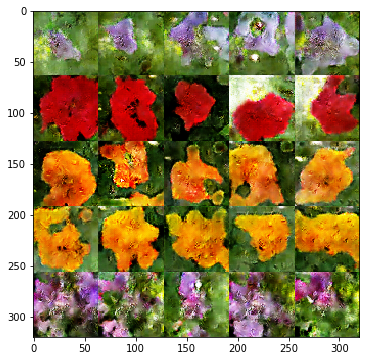

In [43]:
plt.figure(figsize=(6, 6))
plt.imshow(merge(z,[5, 5]))

## 6. Experiments and Finding

1. Normalization: 我們嘗試將圖片normalize到(0, 1)與(-1, 1)。根據結果我們發現若將圖片normalize到(-1, 1)，圖片會有較好的畫質，花朵本身也相較起來更為清晰，但是藍色的花朵卻都沒有辦法有好的生成結果。相較起來，若將圖片normalize到(0, 1)，雖然圖片的畫質較差，但藍色的花朵都可以生成的出來，最後我們也選擇將圖片normalize到(0, 1)。
2. WGAN-GP: 我們嘗試使用過WGAN-GP以增進結果，但效果出來非常的差。
3. Noise的維度: 我們在嘗試的過程中發現noise的維度跟text embedding的維度之間有相關。若是text embedding的維度太高，不同的noise都會生成出相似的結果，所以我們也花了一些時間在嘗試兩者維度的關係。
4. Train比較多次Discriminator: 老師的slides上寫到Discriminator可以train比較多次，但paper上卻是Discriminator train一次、Generator train一次，所以我們有嘗試過train 3次Discriminator再train 1次Generator，但效果同樣沒有變好。
5. 調小noise的standard deviation: 在Github上看到noise的standard deviation可能也會影響圖片品質，一般來說建議可以將standard deviation調小試試，但我們嘗試過將standard deviation調到0.4與0.7，都沒有效果。

#### Train比較多次Discriminator

In [ ]:
@tf.function
def train_step_gene(real_image, real_caption, wrong_image, wrong_caption):
    noise = tf.random.normal(shape=[hparas['BATCH_SIZE'], hparas['Z_DIM']], mean=0.0, stddev=1.0)
    real_text_embed = text_encoder(real_caption)
    wrong_text_embed = text_encoder(wrong_caption)
    
    with tf.GradientTape() as gen_tape:
        _, fake_image = generator(real_text_embed, noise)
        
        real_logits, real_output = discriminator(real_image, real_text_embed)
        fake_logits, fake_output = discriminator(fake_image, real_text_embed)
        mismatch_text_logits, mismatch_text_output = discriminator(real_image, wrong_text_embed)
        
        g_loss = generator_loss(fake_logits)
        d_loss = discriminator_loss(real_logits, fake_logits, mismatch_text_logits)
        
    grad_g = gen_tape.gradient(g_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(grad_g, generator.trainable_variables))
    
    return g_loss, d_loss

@tf.function
def train_step_disc(real_image, real_caption, wrong_image, wrong_caption):
    noise = tf.random.normal(shape=[hparas['BATCH_SIZE'], hparas['Z_DIM']], mean=0.0, stddev=1.0)
    real_text_embed = text_encoder(real_caption)
    wrong_text_embed = text_encoder(wrong_caption)
    
    with tf.GradientTape() as disc_tape:
        _, fake_image = generator(real_text_embed, noise)
        
        real_logits, real_output = discriminator(real_image, real_text_embed)
        fake_logits, fake_output = discriminator(fake_image, real_text_embed)
        mismatch_text_logits, mismatch_text_output = discriminator(real_image, wrong_text_embed)
        
        g_loss = generator_loss(fake_logits)
        d_loss = discriminator_loss(real_logits, fake_logits, mismatch_text_logits)
        
    grad_d = disc_tape.gradient(d_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(grad_d, discriminator.trainable_variables))
    
    return g_loss, d_loss


total_train = (train_step_disc, train_step_disc, train_step_disc, train_step_gene)
total_ctr = len(total_train)

## 7. Conclusion

這次的競賽中我們有以下幾點結論：
1. 多做一些實驗可以幫助了解不同的設定之下的影響。例如，normalize到(0, 1)與(-1, 1)的差異是我們在最後一刻才發現的，也靠著這個影響而提升了一些成績。
2. 可以先參考paper或是Github上其他人的架構再做調整，會比自己從頭開始嘗試要有效率許多，也比較容易有結果。